<a href="https://colab.research.google.com/github/Bokocki/135UM-Homework/blob/main/Homework09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
2. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




# Solution to the homework
---
## Training a neural net

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Training code from the class
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), 
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)  

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   

net.train()    
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)  
                                            
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        loss.backward()
        optimizer.step()

    print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())

Working on cpu
epoch: 0 batch: 29 current batch loss: 0.27196869254112244
epoch: 1 batch: 29 current batch loss: 0.12907008826732635
epoch: 2 batch: 29 current batch loss: 0.10331803560256958
epoch: 3 batch: 29 current batch loss: 0.08948229998350143
epoch: 4 batch: 29 current batch loss: 0.0840362161397934
epoch: 5 batch: 29 current batch loss: 0.0542801134288311
epoch: 6 batch: 29 current batch loss: 0.05216909572482109
epoch: 7 batch: 29 current batch loss: 0.032552823424339294


In [2]:
# Measuring the accuracy of the neural net
good = 0
wrong = 0

net.eval()        
for batch, data in enumerate(testloader):
    datapoint, label = data

    prediction = net(datapoint.to(device))              
    classification = torch.argmax(prediction)

    if classification.item() == label.item():
        good += 1
    else:
        wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9825


## First task

Step 0, Loss: 3.6324, Confidence: [0.0, 0.791, 0.894, 0.118, 0.289, 0.105, 0.002, 0.312, 0.001, 0.001]
Step 100, Loss: 0.0012, Confidence: [0.994, 1.0, 1.0, 1.0, 1.0, 0.999, 0.999, 1.0, 1.0, 0.997]
Step 200, Loss: 0.0007, Confidence: [0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 0.998]
Step 300, Loss: 0.0005, Confidence: [0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 0.999]
Step 400, Loss: 0.0003, Confidence: [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999]
Step 500, Loss: 0.0003, Confidence: [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999]
Step 600, Loss: 0.0002, Confidence: [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 700, Loss: 0.0002, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 800, Loss: 0.0001, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 900, Loss: 0.0001, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 999, Loss: 0.0001, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

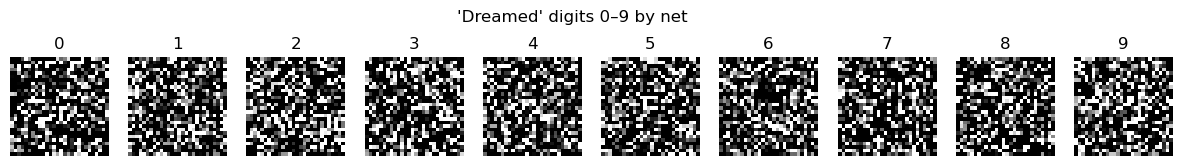

In [3]:
# Gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Setting target classes for images
target_classes = torch.arange(10, device=device)

# Optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# "Dreaming" procedure; optimizing random gaussian input images
for step in range(1000):

    # Freezing weights of the net
    optimizer.zero_grad()

    # Defining loss function and optimizing
    logits = net(dreamed_inputs)
    loss = torch.nn.functional.cross_entropy(logits, target_classes)
    loss.backward()
    optimizer.step()

    # Displaying values of loss function and probabilities
    if step % 100 == 0 or step == 999:
        with torch.no_grad():
            probs = torch.nn.functional.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# Preparing for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# Vizualization of "dreamed" digits by the network
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()

The generated images do not resemble MNIST digits at all. In most cases, there are no human-recognizable patterns that resemble actual numbers. Yet, the neural network classifies these images with near-perfect confidence, as shown by the high output probabilities.

This happens because the optimization process does not constrain the inputs to look like human-readable digits — it only aims to find activation patterns that the network associates with each class. The network has learned certain statistical features from the MNIST dataset that strongly trigger specific outputs, but these features can differ significantly from what humans intuitively recognize as digits.

In this sense, the “dreamed” images reflect what each class means to the neural network – not a human-readable symbol, but a specific configuration of features that maximizes the probability of a given class. These configurations can involve complex, abstract patterns that are effectively meaningless to the human eye. The lack of any regularization during optimization exacerbates the issue, leading to highly noisy, unnatural images.

## Second task

Step 0
  Class 2: 0.0140
  Class 5: 0.5624
  Class 7: 0.3611

Step 200
  Class 2: 0.3211
  Class 5: 0.3211
  Class 7: 0.3213

Step 400
  Class 2: 0.3249
  Class 5: 0.3249
  Class 7: 0.3250

Step 600
  Class 2: 0.3269
  Class 5: 0.3269
  Class 7: 0.3270

Step 800
  Class 2: 0.3281
  Class 5: 0.3281
  Class 7: 0.3282

Step 999
  Class 2: 0.3289
  Class 5: 0.3289
  Class 7: 0.3290



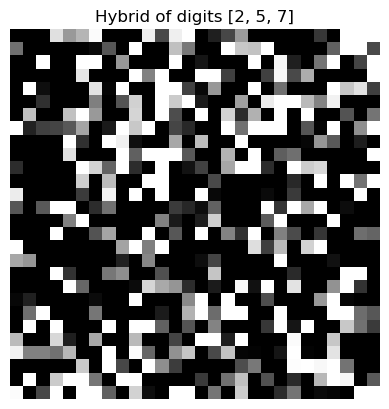

In [4]:
# Choosing three digits
target_classes = [2, 5, 7]

# Generating one random gaussian noise image
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

# Setting up optimizer
optimizer = torch.optim.Adam([hybrid_input], lr=0.01)

for step in range(1000):
    
    # Freezing weights
    optimizer.zero_grad()


    logits = net(hybrid_input)
    probs = torch.nn.functional.softmax(logits, dim=1)

    # We will want to maximize probability of the image being in class "2", "5" and "7" simultaneously
    target_probs = probs[0, target_classes]

    # Probability of a digit being 2, 5 or 7
    prob2 = probs[0, target_classes[0]]
    prob5 = probs[0, target_classes[1]]
    prob7 = probs[0, target_classes[2]]

    # Defining loss function
    loss = (prob2 - 1/3) ** 2 + (prob5 - 1/3) ** 2 + (prob7 - 1/3) ** 2

    # Optimizing
    loss.backward()
    optimizer.step()

    # Displaying values of loss function and probabilities of class "2", "5" and "7"
    if step % 200 == 0 or step == 999:
        print(f"Step {step}\n"
          f"  Class {target_classes[0]}: {target_probs[0].item():.4f}\n"
          f"  Class {target_classes[1]}: {target_probs[1].item():.4f}\n"
          f"  Class {target_classes[2]}: {target_probs[2].item():.4f}\n")

# Preparing for vizualization
hybrid_image_vis = hybrid_input.detach().cpu().clone()
hybrid_image_vis = hybrid_image_vis.clamp(0, 1)

# Vizualization
plt.imshow(hybrid_image_vis[0, 0], cmap='gray')
plt.axis('off')
plt.title(f"Hybrid of digits {target_classes}")
plt.show()

In the second task, we attempted to generate an image that bares similarity to digits 2, 5 and 7 simultaneously, according to the neural net. We adapted the procedure from the first task but modified the loss function to encourage the network to assign equal probability to these three classes. Instead of using cross-entropy loss, we defined
$$
\textrm{Loss} = (p_2-\frac{1}{3})^2 + (p_5-\frac{1}{3})^2 + (p_7-\frac{1}{3})^2
$$
where $p_i$ denotes the model’s predicted probability for class $i$. This formulation penalizes deviations from a uniform distribution over the three target classes, thereby pushing the network to assign approximately one-third probability to each of them. The printed output at each step confirms that the optimization succeeds in achieving this balance.

To generalize this approach to any set of $n$ digits, one can extend the loss function accordingly, replacing $1/3$ with $1/n$ for each class in the target set. As in the first task, the resulting image does not really resemble any recognizable digit or combination of digits.

## Third task

### Modification of the second task

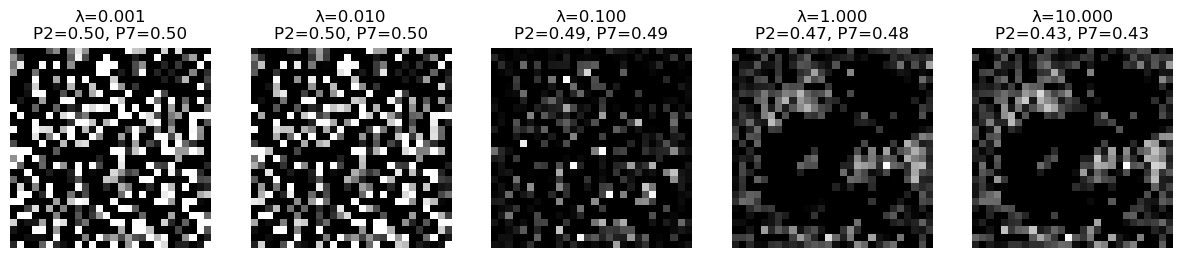

In [5]:
# Choosing the digits
target_classes = [2, 7]

# Preparing set of lambdas
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# Preparing for further vizualization
fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 3))

# Random gaussian noise as input
base_input = torch.randn((1, 1, 28, 28), device=device)

for i, lambda_l2 in enumerate(lambda_values):

    # Preparing input image
    hybrid_input = base_input.clone().detach().requires_grad_(True)

    # Preparing optimizer
    optimizer = torch.optim.Adam([hybrid_input], lr=0.01)

    # Optimization procedure (similar to the second task)
    for step in range(1000):
        optimizer.zero_grad()
        logits = net(hybrid_input)
        probs = torch.nn.functional.softmax(logits, dim=1)

        prob2 = probs[0, target_classes[0]]
        prob7 = probs[0, target_classes[1]]

        target_loss = (prob2 - 1/2) ** 2 + (prob7 - 1/2) ** 2

        # Introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * hybrid_input.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

    # Preparing for vizualization
    img = hybrid_input.detach().cpu().clone()
    img = img.clamp(0, 1)

    # Vizualization
    axs[i].imshow(img[0, 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"λ={lambda_l2:.3f}\nP2={prob2.item():.2f}, P7={prob7.item():.2f}")

In this experiment, we introduced L2 regularization while generating an image that could be interpreted as an equal mix of 2 and 7. The effect of varying the regularization strength $\lambda$ is clearly visible on the output pictures.

As expected, with low regularization (e.g., $\lambda = 0.001$), the generated images remain highly noisy and largely incomprehensible to the human eye. The network is still able to assign high confidence (close to 0.5) to both target classes, but the visual patterns are not interpretable.

As the regularization strength increases, the images become less noisy and start to exhibit faint features that resemble human-recognizable parts of the digits. For instance, in the most regularized case ($\lambda = 10$), we can sort of discern elements reminiscent of a "2" and a "7" — such as the top horizontal stroke (red on the picture below) and the middle slanted stroke (blue on the picture below). This, however, comes at the cost of lower classification confidence – the predicted probabilities drop slightly (from 0.5 to around 0.4).

![MNIST](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW09.png)

### Modification of the first task

λ=0.001, Step 0, Loss: 5.9554, P(class): [0.0, 0.004, 0.003, 0.972, 0.0, 0.013, 0.0, 0.036, 0.0, 0.001]
λ=0.001, Step 500, Loss: 0.0014, P(class): [0.999, 0.999, 0.999, 1.0, 0.999, 1.0, 0.999, 1.0, 1.0, 0.999]
λ=0.001, Step 999, Loss: 0.0011, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 0, Loss: 5.9643, P(class): [0.0, 0.004, 0.003, 0.972, 0.0, 0.013, 0.0, 0.036, 0.0, 0.001]
λ=0.010, Step 500, Loss: 0.0095, P(class): [0.999, 0.999, 0.999, 1.0, 0.999, 1.0, 0.999, 1.0, 1.0, 0.999]
λ=0.010, Step 999, Loss: 0.0086, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.100, Step 0, Loss: 6.0532, P(class): [0.0, 0.004, 0.003, 0.972, 0.0, 0.013, 0.0, 0.036, 0.0, 0.001]
λ=0.100, Step 500, Loss: 0.0705, P(class): [0.999, 0.999, 0.999, 1.0, 0.999, 1.0, 0.999, 1.0, 0.999, 0.999]
λ=0.100, Step 999, Loss: 0.0468, P(class): [0.999, 0.999, 0.999, 1.0, 0.999, 1.0, 0.999, 1.0, 0.999, 0.999]
λ=1.000, Step 0, Loss: 6.9426, P(class): [0.0, 0.004, 0.003, 0.972, 0.0,

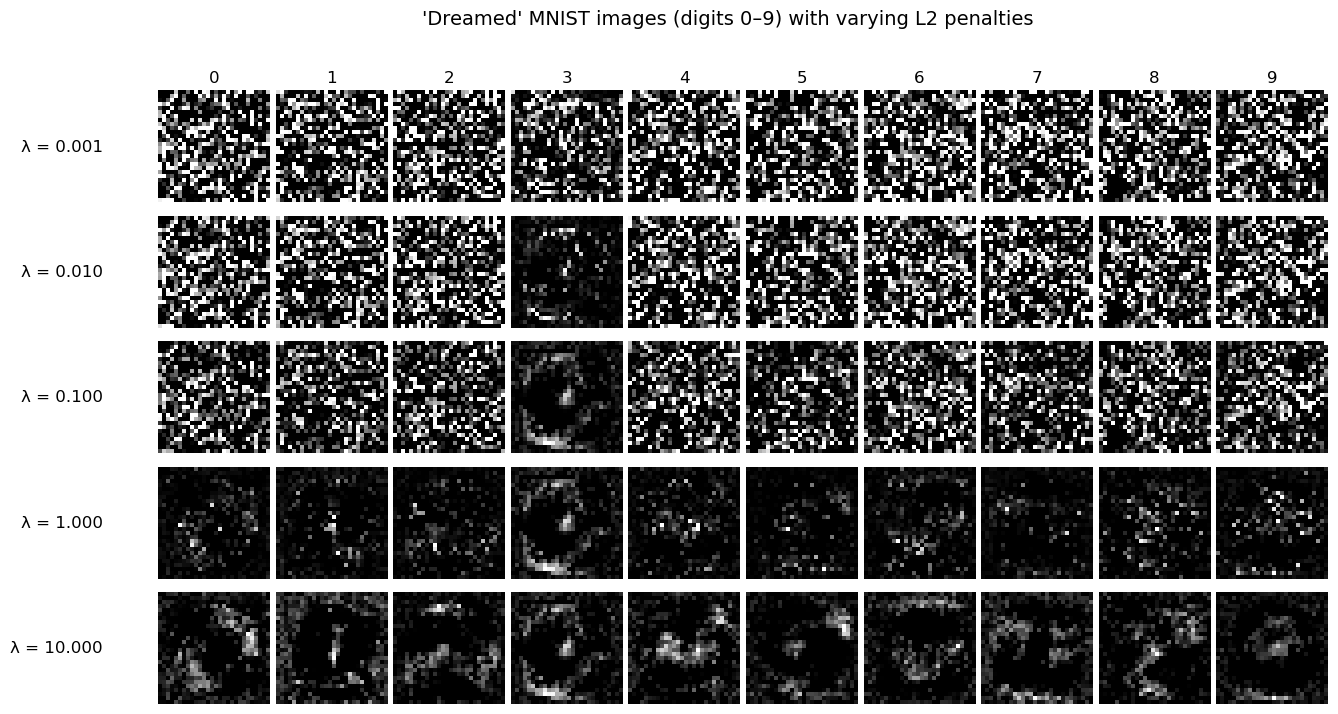

In [10]:
# Generating 10 random gaussian noise iamges
base_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Setting target classes for images
target_classes = torch.arange(10, device=device)

# Preparing set of lambda values
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# Preparing for further vizualization
fig, axs = plt.subplots(len(lambda_values), 10, figsize=(15, 8))
if len(lambda_values) == 1:
    axs = axs.unsqueeze(0)

# "Dreaming" procedure for every lambda
for i, lambda_l2 in enumerate(lambda_values):

    # Getting input images
    dreamed_inputs = base_inputs.clone().detach().requires_grad_(True)

    # Preparing optimizer
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    # Optimizing procedure
    for step in range(1000):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        probs = torch.nn.functional.softmax(logits, dim=1)
        target_loss = torch.nn.functional.cross_entropy(logits, target_classes)

        # Introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

        # Displaying values of loss function and probabilities of "correct" classification
        if step % 500 == 0 or step == 999:
            prob_class = probs.gather(1, target_classes.view(-1, 1))
            print(f"λ={lambda_l2:.3f}, Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in prob_class]}")

    # Vizualization
    images = dreamed_inputs.detach().cpu().clamp(0, 1)

    for j in range(10):
        ax = axs[i, j]
        ax.imshow(images[j, 0], cmap='gray')
        ax.axis('off')

        # Labeling each row with lambda
        if j == 0:
            ax.annotate(f"λ = {lambda_l2:.3f}", xy=(0, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='right', va='center', rotation=0,xytext=(-40, 0),
                        textcoords='offset points')
        if i == 0:
            ax.set_title(str(j), fontsize=12)

plt.suptitle("'Dreamed' MNIST images (digits 0–9) with varying L2 penalties", fontsize=14)
plt.subplots_adjust(top=0.88, left=0.12, wspace=0.05, hspace=0.1)
plt.show()

The results here closely mirror those from the earlier experiment – adding L2 regularization during the optimization process decreases the model’s classification confidence, but significantly improves the interpretability of the generated images.

With minimal regularization, the outputs remain noisy and largely uninterpretable. As regularization increases, the images become cleaner and begin to resemble actual digits. At the highest level of regularization, we can distinguish characteristic features of some of the digits — for instance, the loop in "0", the vertical stroke in "1", or the two loops in "8". These recognizable patterns suggest that the network relies on features that, while not explicitly trained to be human-readable, align with our own perception of digits.

Regularization acts as a constraint, discouraging the network from relying on noise to achieve high classification confidence. Instead, it pushes the optimization toward simpler, smoother patterns — effectively forcing the network to "decide" on the most important features for each digit. Interestingly, these features turn out to be visually meaningful to humans.

In short, L2 regularization makes the network’s internal representations more accessible and interpretable to humans, at the cost of reduced classification certainty.